In [1]:
# CNN model for predicting Sex from ECGs
import tensorflow as tf # Make sure that python interpreter is 3.9.13 Global env
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU')


[]

In [2]:

### Loading raw data into mutable Datframes
ptb = pd.read_csv('../data/ptbxl_database.csv')
def load_raw_data(df, sampling_rate, path):
    if(sampling_rate == 100):
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data



In [3]:

sampling_rate=100
# load and convert annotation data
Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


In [4]:

# Load raw signal data
X = load_raw_data(Y, 100, '../data/')


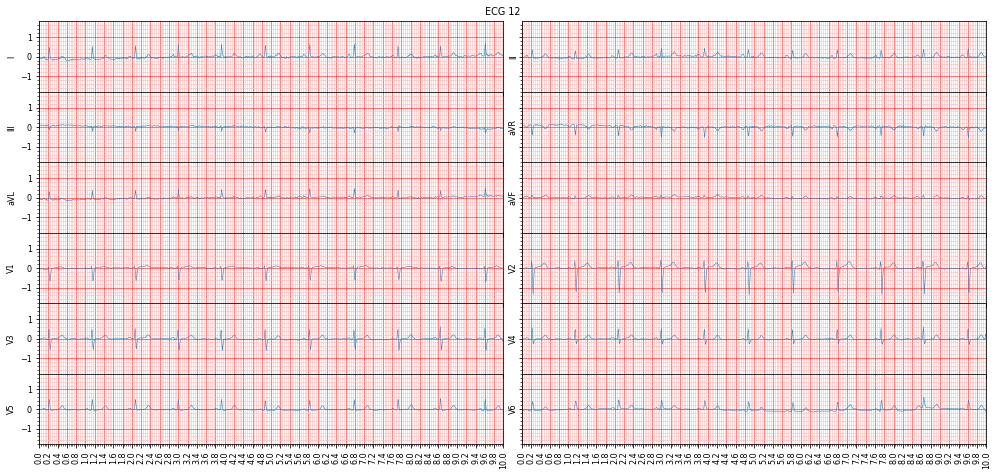

In [5]:
ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)

In [6]:

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

agg_df.head()


,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [7]:

Y_pd = pd.DataFrame(Y)
Y_pd.head()


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


## Data Augmentation

### Band Pass Filter

### Normalization

In [12]:

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X, axis=(-1), keepdims=True)
    X_std = np.std(X, axis=(-1), keepdims= True)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

### Baseline Drift Augmentation

In [15]:
import random
# Defining constant BL drift
bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape[0])
    return X + np.expand_dims(random_shifts, axis=(1, 2))

### DA Applyer

In [16]:
def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

func_dict = [{'func': normalize, 'params': [None]}, 
             {'func': baseline_drift, 'params': [0.5,1]}]

X_final = da_apply(X, func_dict)


### Splitting data in train, validation, testing data set

In [17]:

# Split data into train and test
test_fold =10
val_fold = 9

def tvt_split(X, Y, val_fold, test_fold, shape = False):
    X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
    y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

    X_val = X[Y.strat_fold == val_fold]
    y_val = Y[Y.strat_fold == val_fold].age

    X_test = X[(Y.strat_fold == test_fold)]
    y_test = Y[Y.strat_fold == test_fold].age

    y_train = pd.get_dummies(y_train)
    y_val = pd.get_dummies(y_val)
    y_test = pd.get_dummies(y_test)

    y_train = y_train.idxmax(axis = 1).to_numpy()
    y_val = y_val.idxmax(axis = 1).to_numpy()
    y_test = y_test.idxmax(axis = 1).to_numpy()

    if(shape == True):
        print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


### Analysis of Age Data

(array([  3.,  78., 102., 189., 277., 455., 505., 352., 203.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,  34.]),
 array([  4.        ,  13.86666667,  23.73333333,  33.6       ,
         43.46666667,  53.33333333,  63.2       ,  73.06666667,
         82.93333333,  92.8       , 102.66666667, 112.53333333,
        122.4       , 132.26666667, 142.13333333, 152.        ,
        161.86666667, 171.73333333, 181.6       , 191.46666667,
        201.33333333, 211.2       , 221.06666667, 230.93333333,
        240.8       , 250.66666667, 260.53333333, 270.4       ,
        280.26666667, 290.13333333, 300.        ]),
 <BarContainer object of 30 artists>)

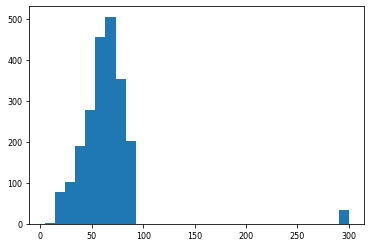

In [18]:
plt.hist(y_test, bins = 30)

### Data manipulation
* The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards as stated by the PTB-XL data page.

### Defining a new Reduced training and test dataset without pateints ages 89 years or older

In [19]:
#Defining a new training and test set that removes pateints 89 years or older.
rX_train = X_train[np.where(y_train <89)]
ry_train = y_train[np.where(y_train <89)]

rX_val = X_val[np.where(y_val <89)]
ry_val = y_val[np.where(y_val <89)]

rX_test = X_test[np.where(y_test <89)]
ry_test = y_test[np.where(y_test <89)]



rX_train.shape, rX_val.shape, rX_test.shape, ry_train.shape, ry_val.shape, ry_test.shape

((17133, 1000, 12),
 (2128, 1000, 12),
 (2147, 1000, 12),
 (17133,),
 (2128,),
 (2147,))

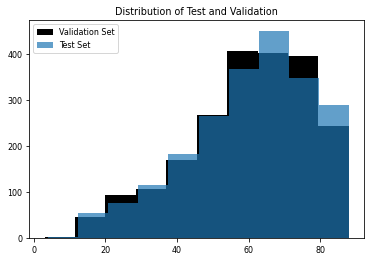

In [20]:
# Plotting the histograms
hist_val = plt.hist(ry_val, label='Validation Set', color="black")
hist_test = plt.hist(ry_test, label='Test Set', alpha = 0.7)

plt.legend()
plt.title("Distribution of Test and Validation")

plt.show()

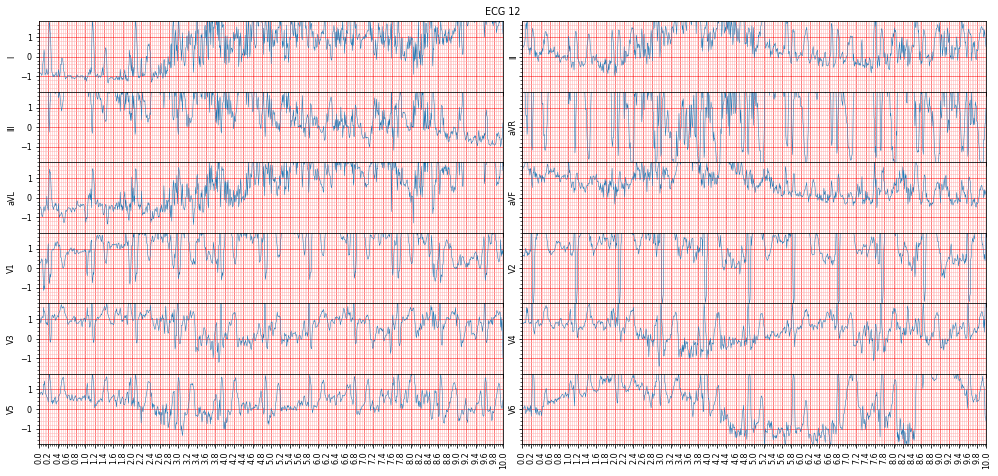

In [21]:
ecg_plot.plot_12(tf.transpose(X_train, (0,2,1))[0], sample_rate=100)

### Further Data manipulation
We however do not recommend the use of time inversion, spatial inversion, permutation, and lead shuffling, whereas a careful design of all other basic DA techniques is needed. 